In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import faiss

In [3]:
# Load model directly
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("posicube/Llama2-chat-AYT-13B")

In [4]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [5]:
with open("vocab.txt", "w") as file:
    file.write(str(tokenizer.vocab))

In [6]:
inputs = ["it has been said that cheese is good for the body", "hi there"]

In [7]:
llamaOutputs = tokenizer(inputs, padding="longest")
llamaOutputs['input_ids'][0]

[1, 372, 756, 1063, 1497, 393, 923, 968, 338, 1781, 363, 278, 3573]

In [8]:
# so now we know how to use tokenizers
# we can use faiss to compare tokenizers

In [9]:
bertTokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
open("bertVocab.txt", "w").write(str(bertTokenizer.vocab))

522321

In [11]:
bertOutputs = bertTokenizer(inputs, padding="longest")
bertOutputs["input_ids"][0]

[101, 2009, 2038, 2042, 2056, 2008, 8808, 2003, 2204, 2005, 1996, 2303, 102]

In [12]:
len(bertOutputs['input_ids'][0])

13

In [13]:
len(llamaOutputs['input_ids'][0])

13

In [14]:
index = faiss.IndexFlatL2(13)

In [15]:
index.is_trained

True

In [16]:
import numpy as np

In [17]:
index.add(np.array([bertOutputs['input_ids'][0], llamaOutputs['input_ids'][0]], dtype=np.float32))

In [18]:
index.ntotal

2

In [19]:
from transformers import AutoModelForMaskedLM

bertModel = AutoModelForMaskedLM.from_pretrained("bert-base-uncased").cpu()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
bertModel.base_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [21]:
bertEmbeddings = bertModel.get_input_embeddings()

In [22]:
bertEmbeddings

Embedding(30522, 768, padding_idx=0)

In [23]:
bertEmbeddings.cpu()

Embedding(30522, 768, padding_idx=0)

## Playing around with pipelines

In [24]:
encodedInput = bertTokenizer("hi there, I would like to order a [MASK] please", return_tensors="pt")

In [25]:
for item in encodedInput:
    encodedInput[item].cpu()

In [26]:
encodedInput

{'input_ids': tensor([[ 101, 7632, 2045, 1010, 1045, 2052, 2066, 2000, 2344, 1037,  103, 3531,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [27]:
output = bertModel(**encodedInput)
output

MaskedLMOutput(loss=None, logits=tensor([[[ -6.8868,  -6.8263,  -6.8384,  ...,  -6.1582,  -6.0658,  -4.1332],
         [ -9.0659,  -9.1499,  -9.4144,  ...,  -8.8747,  -8.6684,  -7.9443],
         [ -8.8072,  -8.6691,  -9.0157,  ...,  -6.5108,  -9.4665,  -7.6807],
         ...,
         [ -6.2883,  -6.2995,  -6.2399,  ...,  -5.8153,  -5.8282,  -7.1735],
         [ -9.1955,  -8.7199,  -9.0054,  ...,  -8.0317,  -9.5727,  -4.0663],
         [-12.7245, -12.4730, -12.4347,  ..., -10.1119, -11.0987,  -9.5461]]],
       grad_fn=<ViewBackward0>), hidden_states=None, attentions=None)

In [28]:
from transformers import pipeline

In [29]:
pipe = pipeline("fill-mask", model=bertModel, tokenizer=bertTokenizer)

In [30]:
pipe("hi there, I would like to order a [MASK] please")

[{'score': 0.45235180854797363,
  'token': 10733,
  'token_str': 'pizza',
  'sequence': 'hi there, i would like to order a pizza please'},
 {'score': 0.08983268588781357,
  'token': 4157,
  'token_str': 'coffee',
  'sequence': 'hi there, i would like to order a coffee please'},
 {'score': 0.08926834911108017,
  'token': 4392,
  'token_str': 'drink',
  'sequence': 'hi there, i would like to order a drink please'},
 {'score': 0.04524002969264984,
  'token': 5404,
  'token_str': 'beer',
  'sequence': 'hi there, i would like to order a beer please'},
 {'score': 0.028834141790866852,
  'token': 11642,
  'token_str': 'sandwich',
  'sequence': 'hi there, i would like to order a sandwich please'}]

In [31]:
import torch

In [32]:
# 10 since that's the index of 103 (the [MASK] token)
temp = torch.softmax(output.logits[0, 10], 0)

In [33]:
highest_prob = torch.argmax(temp)
print("highest prob occurs at", highest_prob, "and is", temp[highest_prob])
print("this is the word", bertTokenizer.decode(highest_prob))

highest prob occurs at tensor(10733) and is tensor(0.4524, grad_fn=<SelectBackward0>)
this is the word pizza


## Actually Using Embeddings

In [34]:
help(bertEmbeddings.forward)

Help on method forward in module torch.nn.modules.sparse:

forward(input: torch.Tensor) -> torch.Tensor method of torch.nn.modules.sparse.Embedding instance
    Defines the computation performed at every call.
    
    Should be overridden by all subclasses.
    
    .. note::
        Although the recipe for forward pass needs to be defined within
        this function, one should call the :class:`Module` instance afterwards
        instead of this since the former takes care of running the
        registered hooks while the latter silently ignores them.



In [35]:
bertEmbeddingsOutput = bertEmbeddings(encodedInput['input_ids'])

In [36]:
bertEmbeddingsOutput

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0138, -0.0868,  0.0433,  ..., -0.0652, -0.1024, -0.0509],
         [-0.0749,  0.0071, -0.0074,  ...,  0.0114,  0.0323,  0.0041],
         ...,
         [ 0.0037, -0.0069,  0.0087,  ...,  0.0054, -0.0043, -0.0004],
         [-0.0479, -0.0136, -0.0444,  ...,  0.0245, -0.0535, -0.0050],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [37]:
bertEmbeddingsOutput.shape

torch.Size([1, 13, 768])

## Visualize

In [38]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [39]:
from sklearn.manifold import TSNE

In [40]:
tsne = TSNE(perplexity=2,learning_rate=50)

In [41]:
npBertEmbeddings = bertEmbeddingsOutput.detach().numpy()

In [42]:
npBertEmbeddings.shape

(1, 13, 768)

In [43]:
npBertEmbeddings = npBertEmbeddings[0]

In [44]:
tsne_features = tsne.fit_transform(npBertEmbeddings)

In [45]:
tsne_features.shape

(13, 2)

/home/eliot/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/eliot/miniconda3/envs/torch/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: >

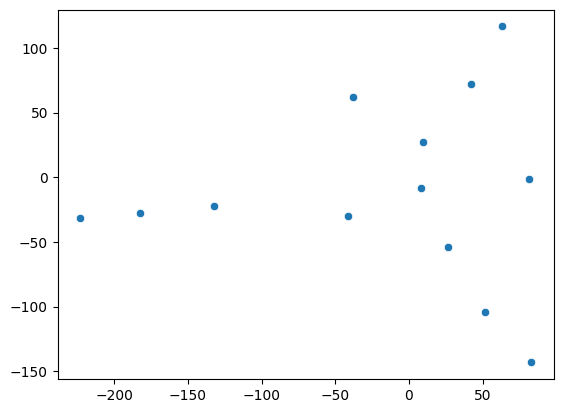

In [46]:
sns.scatterplot(x=tsne_features[:,0], y=tsne_features[:,1])

## LLama thing

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import accelerate

tokenizer = AutoTokenizer.from_pretrained("converted-llama", fp16=True)

model = AutoModelForCausalLM.from_pretrained("converted-llama", load_in_4bit=True, device_map="auto")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
tokenizer.add_special_tokens({"pad_token":"[PAD]", "mask_token":"[MASK]"})

2

In [37]:
encoded = tokenizer("""
There's a llama in my garden 😱 What should I do?
""", return_tensors="pt")
encoded

{'input_ids': tensor([[    1, 29871,    13,  8439, 29915, 29879,   263, 11148,  3304,   297,
           590, 16423, 29871,   243,   162,   155,   180,  1724,   881,   306,
           437, 29973,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [38]:
encoded['input_ids'].shape

torch.Size([1, 23])

In [39]:
output = model.generate(encoded.input_ids, max_length=encoded.input_ids.shape[-1] + 50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [40]:
output

tensor([[    1, 29871,    13,  8439, 29915, 29879,   263, 11148,  3304,   297,
           590, 16423, 29871,   243,   162,   155,   180,  1724,   881,   306,
           437, 29973,    13, 30003, 29992, 29933,  5371, 29934, 29946,    13,
         29902, 29915, 29885,   451,  1854,   825,   304,   437, 29889,   306,
         29915,   345,  2360,   750,   263, 11148,  3304,   297,   590, 16423,
          1434, 29889,    13, 30003, 29992, 29933,  5371, 29934, 29946,    13,
         29902, 29915, 29885,   451,  1854,   825,   304,   437, 29889,   306,
         29915,   345,  2360]])

In [41]:
tokenizer.batch_decode(output)

["<s> \nThere's a llama in my garden 😱 What should I do?\n—@BBCR4\nI'm not sure what to do. I've never had a llama in my garden before.\n—@BBCR4\nI'm not sure what to do. I've never"]